In [82]:
import pandas as pd
import numpy as np

%matplotlib inline


import torch
from torch import nn
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## 从kaggle下载数据集

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c digit-recognizer

 98% 9.00M/9.16M [00:00<00:00, 45.7MB/s]
100% 9.16M/9.16M [00:00<00:00, 44.6MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 146MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 55.8MB/s]


In [ ]:
## 解压文件到当前目录
!unzip train.csv.zip -d ./ 

Archive:  train.csv.zip
  inflating: ./train.csv             


In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
def split_train_valid_set(features,labels):
  ## 分割train valid set
  idx=np.arange(0,len(labels),10)
  valid_set=features[idx]
  valid_label=labels[idx]
  ## 1/10为 valid_set
  idx=[i for i in range(len(labels)) if i%10!=0]
  train_set=features[idx]
  train_label=labels[idx]

  return (train_set,train_label),(valid_set,valid_label)

In [ ]:
## 数据预处理
data=pd.read_csv("./train.csv")
train_data=data.iloc[:,1:]
train_data=train_data.to_numpy()
train_data=(train_data-np.min(train_data,axis=1,keepdims=True))/(np.max(train_data,axis=1,keepdims=True)-np.min(train_data,axis=1,keepdims=True))
train_data=torch.Tensor(train_data)
label=data.iloc[:,0]
label=label.to_numpy()
label=torch.Tensor(label)
(train_set,train_label),(valid_set,valid_label)=split_train_valid_set(train_data,label)

In [84]:
## transform function
def reshape_img(vec):
  out=vec.view((1,28,28))
  return out

def one_hot(num):
  x=torch.zeros(10)
  x[num.long()]=1
  return x


In [85]:
class CustomImageDataset(Dataset):
    def __init__(self, label, img, transform=None, target_transform=None):
        self.labels = label
        self.imgs = img
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        ## 注意此处为了在train和test时都能使用的写法
        if self.labels is not None:
          image = self.imgs[idx]
          label = self.labels[idx]

          ## 进行变换
          if self.transform:
              image = self.transform(image)
          if self.target_transform:
              label = self.target_transform(label)
          
          return image, label
        else:
          image = self.imgs[idx]
          if self.transform:
            image = self.transform(image)
          return image


In [ ]:
training_data=CustomImageDataset(train_label,train_set,reshape_img,one_hot)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
valid_data=CustomImageDataset(valid_label,valid_set,reshape_img,one_hot)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=False)

In [ ]:
def valid(model,valid_dataloador,device,loss_fn,num_valid_sample):
    ## input: model
    ## return: valid acc
    model.eval()

    num_right=0
    with torch.no_grad():
        for X, y in valid_dataloador:
            X, y = X.to(device), y.to(device)

            pred,vect = model(X)

            ## 计算预测准确性
            ls=nn.Softmax(dim=1)
            a=ls(pred)
            idx=torch.argmax(a,dim=1)
            right=y[torch.arange(0,len(idx)),idx]
            num_right+=torch.sum(right)
            
    acc=num_right/num_valid_sample
    return acc

In [90]:
##  定义model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
 
        ## x为通过卷积层后的flatten向量
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        ########### return x for visualization #####################
        return output, x    

In [ ]:
def train(train_dataloader,valid_dataloador, model, loss_fn, optimizer,device):
    train_loss_lst=[]
    valid_acc_lst=[]

    epoch=0
    n_epoch=30
    max_acc=0.01
    early_stop_cnt=0
    early_stop_cnt_max=30

    size = len(train_dataloader.dataset)
    ## 将model调为训练模式
    model.train()

    while epoch<=n_epoch:
        print(f"epoch: {epoch+1},")
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred,vec = model(X)


            ##################################################
            ###计算-log时可能会出现极端值  自己手写的时候要注意  
            ### pytorch应该已经优化过了
            ################################################
            loss = loss_fn(pred, y)


            

            train_loss_lst.append(loss.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
     
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        epoch+=1    
        
        ## 进行模型评估valid
        acc=valid(model,valid_dataloador,device,loss_fn,len(valid_dataloador.dataset))
        valid_acc_lst.append(acc)
        if acc>max_acc:
            max_acc=acc
            torch.save(model.state_dict(),'./model.pth')  
            print(f'epoch: {epoch}, acc is increasing , acc is {acc}')
            early_stop_cnt=0
        else:
            print(f'epoch: {epoch}, acc is {acc}')
            early_stop_cnt+=1
            if early_stop_cnt>=early_stop_cnt_max:
                break
        print("---------------------------")
    return (train_loss_lst,valid_acc_lst)

In [91]:
loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

NeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
(train_loss_lst,valid_acc_lst)=train(train_dataloader,valid_dataloader, model, loss_fn, optimizer,device)

epoch: 1,
loss: 2.299555  [    0/37800]
loss: 2.284030  [ 6400/37800]
loss: 2.258494  [12800/37800]
loss: 2.216041  [19200/37800]
loss: 2.177663  [25600/37800]
loss: 2.117983  [32000/37800]
epoch: 1, acc is increasing , acc is 0.6790476441383362
---------------------------
epoch: 2,
loss: 1.981938  [    0/37800]
loss: 1.932313  [ 6400/37800]
loss: 1.898769  [12800/37800]
loss: 1.695680  [19200/37800]
loss: 1.648542  [25600/37800]
loss: 1.496078  [32000/37800]
epoch: 2, acc is increasing , acc is 0.7780952453613281
---------------------------
epoch: 3,
loss: 1.473880  [    0/37800]
loss: 1.300386  [ 6400/37800]
loss: 1.204085  [12800/37800]
loss: 1.166735  [19200/37800]
loss: 1.003744  [25600/37800]
loss: 1.048886  [32000/37800]
epoch: 3, acc is increasing , acc is 0.8135714530944824
---------------------------
epoch: 4,
loss: 0.893793  [    0/37800]
loss: 0.903706  [ 6400/37800]
loss: 0.850955  [12800/37800]
loss: 0.844471  [19200/37800]
loss: 0.768419  [25600/37800]
loss: 0.593522  [3

[[[ 0.0046196  -0.17975196 -0.04769272 -0.1447104  -0.15203762]
  [ 0.1564641   0.13087675  0.04981941 -0.01300564 -0.15005241]
  [ 0.23341967 -0.04069765 -0.087758    0.05672561  0.00529127]
  [ 0.12660982 -0.02527595  0.17719847  0.2832704   0.24682334]
  [-0.01411771  0.06081422  0.28014275  0.21752231 -0.02450305]]]
------------
0.13430683
------------
[[[ 0.06262829 -0.00105795  0.08439059  0.02796151  0.05185966]
  [ 0.01308961  0.0355148  -0.01169942 -0.02282014  0.02518433]
  [-0.05802576 -0.07186291 -0.04460648  0.05973607  0.01654151]
  [ 0.01537652  0.02808821  0.01864746  0.05935202  0.02931063]
  [-0.00543798 -0.01477929  0.01204546 -0.02291608 -0.05351902]]

 [[-0.00285133 -0.01925833  0.01612761  0.00361229  0.05853289]
  [-0.04713516 -0.07456519 -0.03680347  0.00485963  0.05786131]
  [ 0.04584093  0.02672918  0.02026513 -0.02344584  0.00520404]
  [ 0.06670136  0.02317325 -0.01010068  0.04152089 -0.03995185]
  [-0.02517712  0.02592492  0.05253998  0.06655616 -0.04675691]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


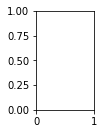

In [ ]:
for name, param in model.named_parameters():
  i=0
  plt.subplot(2,5,i+1)
  print(param[2].detach().numpy())
  print("------------")
  # plt.imshow(param[2].detach().numpy().reshape((5,5)))
  i+=1
  if i==10:
    break
    # print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

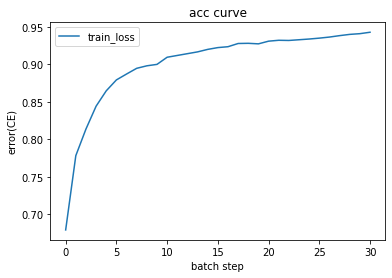

In [ ]:
plt.title("acc curve")
error_string="CE"
x=np.arange(len(valid_acc_lst))
plt.plot(x,valid_acc_lst,label='train_loss')
plt.xlabel("batch step")
plt.ylabel(f"error({error_string})")
plt.legend()
plt.show()

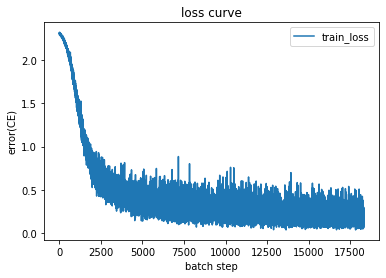

In [ ]:
plt.title("loss curve")
error_string="CE"
x=np.arange(len(train_loss_lst))
plt.plot(x,train_loss_lst,label='train_loss')
plt.xlabel("batch step")
plt.ylabel(f"error({error_string})")
plt.legend()
plt.show()

In [ ]:
!unzip test.csv.zip -d .

Archive:  test.csv.zip
  inflating: ./test.csv              


## load test_data

In [86]:
test_data=pd.read_csv("./test.csv").to_numpy()

In [87]:
test_data=(test_data-np.min(test_data,axis=1,keepdims=True))/(np.max(test_data,axis=1,keepdims=True)-np.min(test_data,axis=1,keepdims=True))
test_data=torch.Tensor(test_data)

In [88]:
test_data=CustomImageDataset(None,test_data,reshape_img,one_hot)
test_dataloador=DataLoader(test_data,batch_size=64,shuffle=False)

In [115]:
prd_lst=[]
model.load_state_dict(torch.load('./model.pth'))
model.eval()
with torch.no_grad():
    for X in test_dataloador:
            X = X.to(device)

            pred,vect = model(X)

            ## 计算预测准确性
            ls=nn.Softmax(dim=1)
            a=ls(pred)
            idx=torch.argmax(a,dim=1)
            for i in range(0,len(idx)):
              prd_lst.append(idx[i].item())

In [ ]:
prd_lst

PREDICT

In [117]:
import csv
with open("starfish.csv", 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['ImageId', 'Label'])
    for i, p in enumerate(prd_lst):
        writer.writerow([i+1, p])

## 现象
1. 图片不归一化，loss=nan
2. 

## 收获
1. dataloader的使用(迭代器的使用)
2. dataloador tansform function使用
3. softmax在自己手写的时候 注意极端情况log(X)=inf